# Program Optimization using `tket-py`

**Download this notebook - {nb-download}`Guppy-opt-example.ipynb`**



In [1]:
from guppylang import guppy
from guppylang.std.quantum import cx, h, qubit, t, rz
#from guppylang.std.qsystem import phased_x, rz
from guppylang.std.angles import pi, angle
from hugr.hugr.render import DotRenderer, RenderConfig
from graphviz import Digraph
from tket.passes import NormalizeGuppy, PytketPass
from pytket.passes import RemoveRedundancies, SquashRzPhasedX, AutoSquash, EulerAngleReduction, FullPeepholeOptimise
from pytket.circuit import OpType

# Configure Hugr visualizer
my_renderer = DotRenderer(RenderConfig(display_node_id=True, display_metadata=False))

def draw(hugr: Hugr) -> Digraph:
    """Draw a Hugr graph with the DotRenderer."""
    return my_renderer.render(hugr)

## Getting started - Flattening the Guppy generated HUGR

In [2]:
@guppy
def pauli_zz_rotation(q0: qubit, q1: qubit) -> None:
    cx(q0, q1)
    t(q1)
    cx(q0, q1)

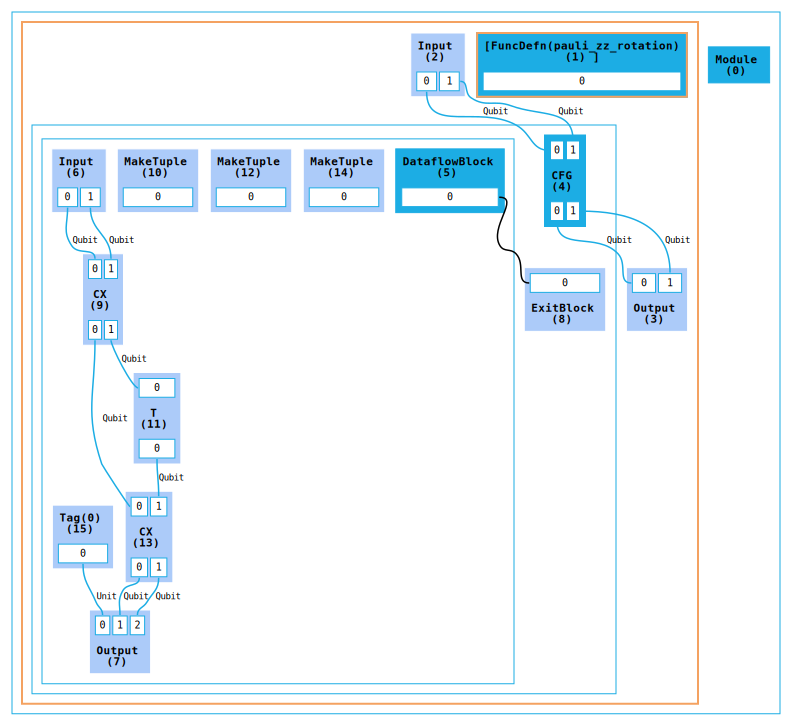

In [3]:
zz_hugr_graph = pauli_zz_rotation.compile_function().modules[0]
draw(zz_hugr_graph)

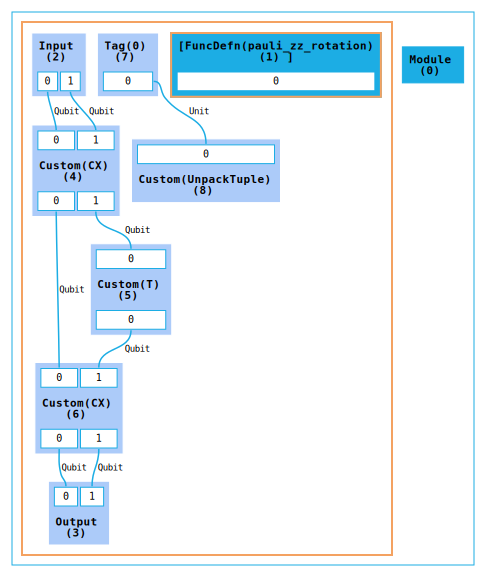

In [4]:
normalize = NormalizeGuppy()

cleaned_zz_hugr = normalize(zz_hugr_graph)

draw(cleaned_zz_hugr)

## Example 1: Cancelling redundant CX gates 

In [5]:
from guppylang.std.angles import angle

@guppy
def redundant_cx(q0: qubit, q1: qubit) -> None:
    h(q0)
    # Two adjacent CX gates with the same control and target can be cancelled.
    cx(q0, q1)
    cx(q0, q1)

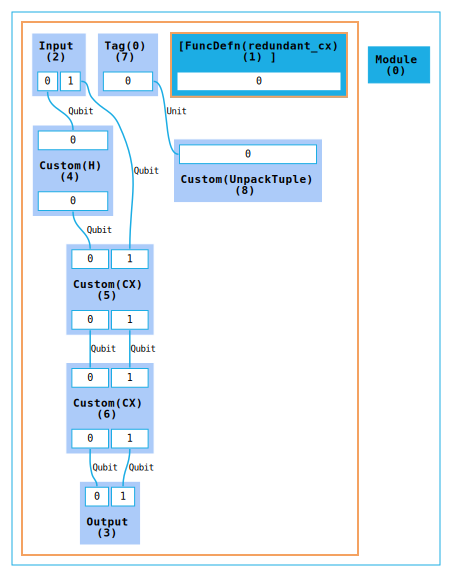

In [6]:
my_hugr_graph = normalize(redundant_cx.compile_function().modules[0]) # get normalized hugr for program above
draw(my_hugr_graph)

In [7]:
rr_pass = PytketPass(RemoveRedundancies())

optimized_hugr = rr_pass(my_hugr_graph)

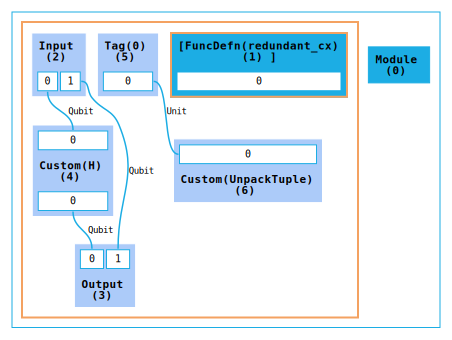

In [8]:
draw(optimized_hugr)

## Issue 1: Simplifying sequences of single qubit gates

Trying to squash parameterised Rz gates gives a `PyTk1EncodeError` complaining about an unsupported subgraph and something to do with barriers

In [9]:
@guppy
def redundant_rz_gates(q0: qubit) -> None:
    h(q0)
    rz(q0, angle(1/2))
    rz(q0, angle(1/2))
    

In [10]:
my_1q_hugr_graph = normalize(redundant_rz_gates.compile_function().modules[0]) # get normalized hugr for program above


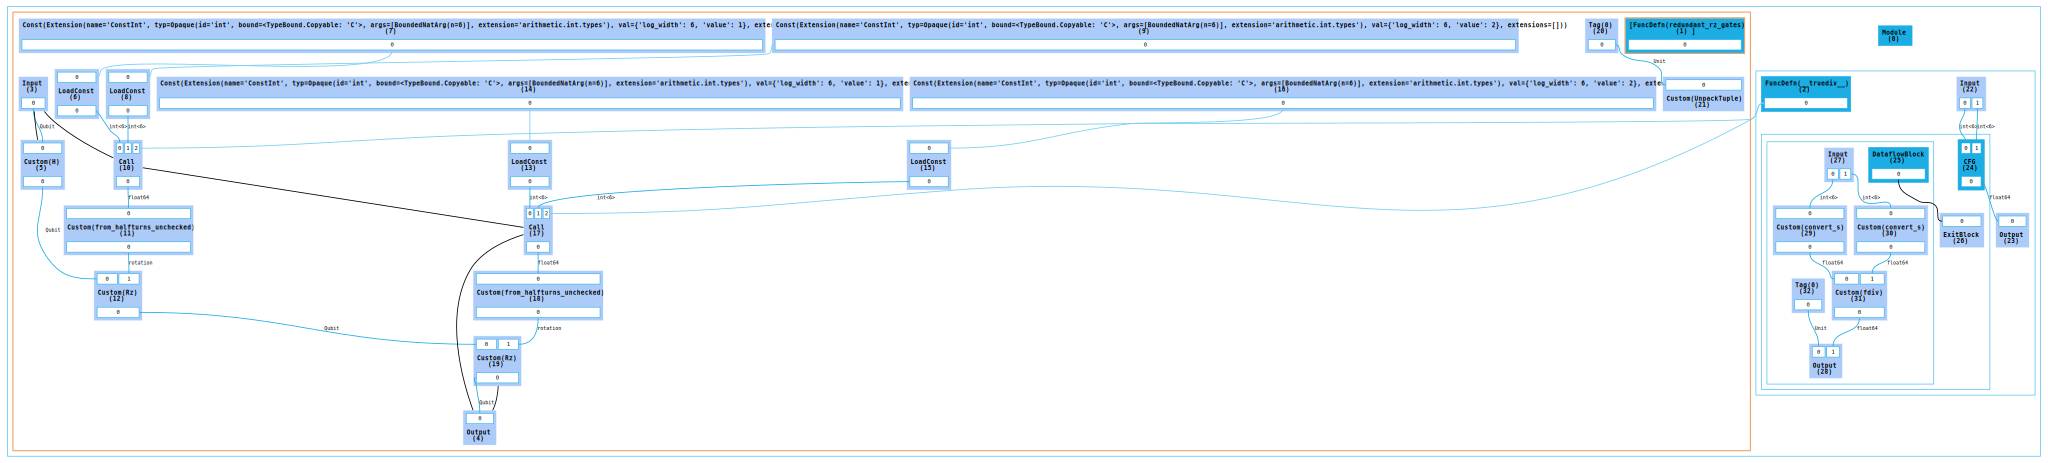

In [11]:
draw(my_1q_hugr_graph)

In [12]:
squash_pass = PytketPass(SquashRzPhasedX())

In [13]:
optimized_1q_hugr = squash_pass(my_1q_hugr_graph)

PyTk1EncodeError: An unsupported subgraph has no qubits or bits to attach the barrier command to

## Issue 2: QSystem ops give an error when `NormalizeGuppy` is applied

Passes fail if the HUGR contains a qystem op. E.g. `phased_x`. This is due to a failure when converting the HUGR to a `Tk2Circuit` in tket-py internals. Failure manifests upon Guppy Normalisation.

In [14]:
from guppylang.std.qsystem import phased_x

@guppy
def qsystem_chain(q: qubit) -> None:
    phased_x(q, angle(0.91), angle(0.5))
    phased_x(q, angle(0.53), angle(0))
    phased_x(q, angle(3.29), angle(0.5))


In [15]:
qsystem_hugr_graph = normalize(qsystem_chain.compile_function().modules[0]) # get normalized hugr for program above

AttributeError: Could not read envelope: OpaqueOp:tket.qsystem.PhasedX in Node(48) requires extension tket.qsystem, but it could not be found in the extension list used during resolution. The available extensions are: TKET1, arithmetic.conversions, arithmetic.float, arithmetic.float.types, arithmetic.int, arithmetic.int.types, collections.array, collections.borrow_arr, collections.list, collections.static_array, collections.value_array, logic, prelude, ptr, tket.bool, tket.debug, tket.guppy, tket.quantum, tket.rotation

## Issue 3: A diagonal gate prior to a measure gives an error upon RR

In [16]:
from guppylang.std.quantum import z, measure
from guppylang.std.angles import angle
from guppylang.std.builtins import owned

@guppy
def redundant_z(q0: qubit @owned, q1: qubit) -> None:
    h(q0)
    cx(q0, q1)
    cx(q0, q1) # interestingly if we remove the CX gates its fine. 
    z(q0)
    measure(q0)

# interestingly if we remove the CX gates and make the function take a single qubit as input it works fine. 

In [17]:
z_graph = normalize(redundant_z.compile_function().modules[0]) # get normalized hugr for program above

In [18]:
rr_pass(z_graph)

PyTK1DecodeError: Discarded qubit q[0] cannot be used as an input. While decoding a hugr Output